# Monte Carlo methods and Application to Ising Model

                Yingjie Wang

                Apr. 19,  2022

## 1. Introduction to the Monte Carlo Method

### 1.1 Background

#### What's the problem?

- In canonical ensemble, everything can be calculated from:
	$$Z = \operatorname{tr}\left(\mathrm{e}^{- \beta \hat{H}}\right) = \sum_{s} \mathrm{e}^{- \beta E_s},$$

- but it's hard to calculate in general!

- You may say that, OK let's do that numerically, but running over the states is still hard

#### What's Monte Carlo Method?

It's hard to define generally...

Here we refer to the *Metropolis Monte Carlo Algorithm*, which will be defined later.

#### How Monte Carlo Solve the problem?

- Every quantity can be calculated by
	$$\left\langle A\right\rangle = \sum_s A(s) \frac{\mathrm{e}^{-\beta E_s}}{Z},$$
	so we can randomly select states according to the probability
	$$p(s) = \frac{\mathrm{e}^{-\beta E_s}}{Z}$$
	and calculate the average on the sample states, instead of run over all states

- The point is: overall constant factor is not matter in the Metropolis algorithm!
- Knowing that
	$$p(s) \propto \mathrm{e}^{- \beta E_s}$$
	is enough. Good News!

### 1.2 The Metropolis algorithm

Suppose that we want a dataset $\{ x_i \}$ that match some probability distribution $p(x)$.

1. Start from any initial value $x_0$;

2. Do the following loop:
	1. suppose we already have $x_i$. Move to a test value $x^{\prime}_{i+1}$ for $x_{i+1}$ randomly from $x_i$ according to any symmetric distribution $T(x_{i+1},x_i)$ (but must make sure that $x^{\prime}_{i+1} \neq x_i$);
	2. accept the change according to the probability $A(x^\prime_j,x_i) = \min(1, p(x^\prime_j)/p(x_i))$. If we accept the move, then $x_{i_1} = x^\prime_{i+1}$; else we throw $x^\prime_j$ and take $x_{i+1} = x_i$.
   	**Note that the algorithm only depends on** $p(y)/p(x)$**, any overall factor doesn't matter!**

3. After many loops, the distribution of $\{ x_i \}$ will converge to $\propto p(x)$.

4. Then throw all $x_i$ generated before, just leave the last one, then do more loops to collect enough samples.

#### Example: coding time

In [1]:
import numpy as np
from matplotlib import pyplot as plt
rng = np.random.default_rng()

In [2]:
def p(x):
	return np.exp(-x*x/2)
def metro_norm(stepnum: int, dx: float) -> np.array:
	x = np.empty(stepnum)
	x[0] = -10
	for i in range(stepnum-1):
		y = x[i] + (rng.random()-0.5)*dx
		if rng.random() < p(y)/p(x[i]):
			x[i+1] = y
		else:
			x[i+1] = x[i]
	return x
xlist = metro_norm(10000,0.5)

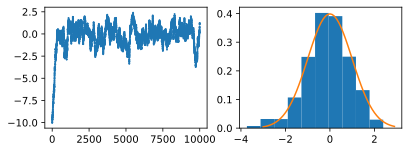

In [3]:
# plot
plt.subplot(2, 2, 1) 
plt.scatter(range(10000),xlist,s=1)
plt.subplot(2, 2, 2)
plt.hist(xlist[3000:],density=True)
plt.plot(np.arange(-3,3,step=0.1),p(np.arange(-3,3,step=0.1))/np.sqrt(2*np.pi))
%config InlineBackend.figure_format='svg'
plt.show()

only 10000 run in $0.6 s$, but still not bad, right?

## 2 Metropolis algorithms for statistical mechanics

### 2.1 In canonical ensemble

$x_i \rightarrow s_i, \ p(x_i) \rightarrow p(s_i) = \mathrm{e}^{-\beta E}$

The accepting probability is now $p(s_j)/p(s_i) = \mathrm{e}^{- \beta \Delta E}$

- Everything is almost the same, do loops to generate a list of states.

- Calculate $\left< A \right>$ on the sample list

#### Toy model: Ideal gas

- Suppose that we have $N$ particles in $V=L^3$ box.

- For each particle, the energy eigenstates are $\left| \vec{n} \right> = \left| n_1 \right>\left| n_2 \right>\left| n_3 \right>$ with the eigenvalue $E_{\vec{n}} = \frac{\pi^2 \hbar^2}{2mL^2} \left( n_1^2 + n_2^2 + n_3^2 \right)$.

- Take $\hbar = m = L = k = 1$ for convenient.

- The steps:
  - We create a list `n` with shape $N \times 3$ to present the state.
  - Randomly choose one particle $i \in [0,N-1]$ and one direction $j \in [0,2]$, then randomly add $\pm 1$ to `n[i,j]`
  - The change of energy is $\Delta E = \frac{\pi^2}{2} (\pm 2 n_{i,j} + 1)$
  - If `rand()`$< \mathrm{e}^{- E/T}$, then accept the move. Otherwise, keep `n[i,j]` unchanged.
  - Let the computer repeat!

#### The code

In [4]:
from rich.progress import track
def elist(T, N=1000, movenum = 2000000):
	energy = np.pi*np.pi*3*N/2
	nlist = np.ones((N,3))
	energylist = np.empty(movenum)
	for move in track(range(movenum)):
		i,j = rng.integers(N),rng.integers(3)
		x = rng.integers(2)
		if x == 1 or nlist[i,j] > 1:
			dE = (2*nlist[i,j]*(2*x-1) + 1)*np.pi*np.pi/2
			if rng.random() < np.exp(-dE/T):
				nlist[i,j] += 2*x - 1
				energy += dE
		energylist[move] = energy
	return energylist/N

Output()

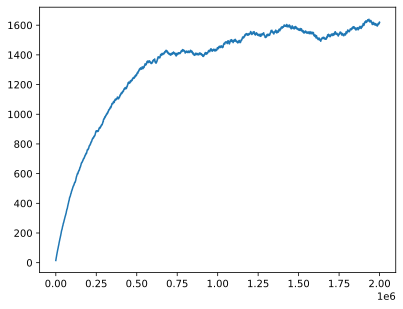

In [5]:
data = elist(1000)
plt.plot(data)
plt.show()

##### Vectorized code

In [6]:
def e_vec(T, N=1000, movenum = 1000000):
	NT = T.size
	energy = np.pi*np.pi*3*N/2
	nlist = np.ones((N,3,NT))
	energylist = np.empty((movenum, NT))
	for move in track(range(movenum)):
		i,j = rng.integers(N),rng.integers(3)
		x = rng.integers(2)
		validlist = ([x == 1] | (nlist[i,j] > 1))
		dE = (2*nlist[i,j]*(2*x-1) + 1)*np.pi*np.pi/2
		boollist = rng.random() < np.exp(-dE/T)
		nlist[i,j] += (2*x - 1)*validlist*boollist
		energy += dE*validlist*boollist
		energylist[move] = energy
	elist = np.mean(energylist[movenum//2:],axis=0)
	return elist/N

Output()

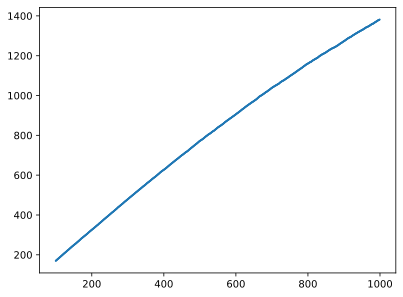

In [7]:
tlist = np.arange(100,1000)
elist = e_vec(tlist)
plt.scatter(tlist,elist, s=1)
plt.show()

When $T$ is a large number (prepare to $\frac{\hbar^2}{kmL^2}$), $e(T)$ recover the straight line $e = \frac{3}{2} T$.

## 3 Ising model

Now let's apply the MC method to a specific system. Here I take Ising model for example.

#### What's it for?

Ising model is used to explain ferromagnet.

![menu](img/mag.png "Why magnet \"store\" magnetic field?")

Questions:

- Why $M \neq 0$ when $\vec{B} = 0$ and $T$ is lower than some value

- Why there's a critical temperature

- ...

#### What's Ising model's answer

In most ordinary materials the magnetic dipoles of the atoms have a random orientation. In effect this non-specific distribution results in no overall macroscopic magnetic moment. However in certain cases, such as iron, a magnetic moment is produced as a result of a preferred alignment of the atomic spins.

Ising model suppose that there's a short-range interaction term in the Hamiltonian:
$$H = - J \sum_{<i,j>} \sigma_{i} \sigma_j - B \sum_i \sigma_i, \quad J>0,$$
where $\sum_{<i,j>}$ means that sum over nearby spin pairs, and $\sigma$ is the $z$-direction spin operator.

But since $\sigma_i$ commute with each other, the Hamiltonian just acts as number. We will treat this model as a "classical" system and treat $\sigma_i$ as a variable taking it's value of $\pm 1$.

The existing of $J$ term can explain the difference between ferromagnetism behavior and paramagnetism behavior.

### 3.1 Ising model on 2D finite square lattice

We introduce the periodic boundary condition on a $N \times N$ lattice, so that each spin always interacts with 4 spins.

Thus the model is defined on a torus.

![torus](img/torus.jpg)

We'll also assuming that
$ B = 0, \quad J=1$.

#### 3.1.1 the Analytical Solution

Just post to show it...

I get the partition function using mathematica for $N=8$ lattice:

$$ Z(\beta) =  \mathrm{e}^{2N^2 \beta} \tilde{Z}(\mathrm{e}^{-2 \beta}),$$
where $\tilde{Z}(x)$ is a polynomial:

$$ \tilde{Z}(x) = 2 x^{128}+128 x^{124}+256 x^{122}+4672 x^{120}+17920 x^{118}+145408 x^{116}+712960 x^{114}+4274576 x^{112}+22128384 x^{110}+118551552 x^{108}+610683392 x^{106}+3150447680 x^{104}+16043381504 x^{102}+80748258688 x^{100}+396915938304 x^{98}+1887270677624 x^{96}+8582140066816 x^{94}+36967268348032 x^{92}+149536933509376 x^{90}+564033837424064 x^{88}+1971511029384704 x^{86}+6350698012553216 x^{84}+18752030727310592 x^{82}+50483110303426544 x^{80}+123229776338119424 x^{78}+271209458049836032 x^{76}+535138987032308224 x^{74}+941564975390477248 x^{72}+1469940812209435392 x^{70}+2027486077172296064 x^{68}+2462494093546483712 x^{66}+2627978003957146636 x^{64}+2462494093546483712 x^{62}+2027486077172296064 x^{60}+1469940812209435392 x^{58}+941564975390477248 x^{56}+535138987032308224 x^{54}+271209458049836032 x^{52}+123229776338119424 x^{50}+50483110303426544 x^{48}+18752030727310592 x^{46}+6350698012553216 x^{44}+1971511029384704 x^{42}+564033837424064 x^{40}+149536933509376 x^{38}+36967268348032 x^{36}+8582140066816 x^{34}+1887270677624 x^{32}+396915938304 x^{30}+80748258688 x^{28}+16043381504 x^{26}+3150447680 x^{24}+610683392 x^{22}+118551552 x^{20}+22128384 x^{18}+4274576 x^{16}+712960 x^{14}+145408 x^{12}+17920 x^{10}+4672 x^8+256 x^6+128 x^4+2 $$

OK, I think you already don't want to see any more equation like this, let's move to the MC method...

#### 3.1.2 Python Time

- Use a table `s[i,j]` to save spins;
- Set any initial state;
- Randomly choose `i,j` to flip the spin;
- $\Delta E = -J(\text{nearby sum}) \times \Delta s_{ij}  = 2J(\text{nearby sum})*s_{ij}$;
- When `random()` ${}< \mathrm{e}^{-\Delta E/T}$, accept the flip;
- Let the computer repeat!

##### Test

In [10]:
def gqlist(N):
	if N==2:
		return [2, 0, 12, 0, 2]
	elif N== 4:
		return [2,0,32,64,424,1728,6688,13568,20524,13568,6688,1728,424,64,32,0,2]
	elif N== 8:
		return [2, 0, 128, 256, 4672, 17920, 145408, 712960, 4274576, 22128384, 118551552, 610683392, 3150447680, 16043381504, 80748258688, 396915938304, 1887270677624, 8582140066816, 36967268348032, 149536933509376, 564033837424064, 1971511029384704, 6350698012553216, 18752030727310592, 50483110303426544, 123229776338119424, 271209458049836032, 535138987032308224, 941564975390477248, 1469940812209435392, 2027486077172296064, 2462494093546483712, 2627978003957146636, 2462494093546483712, 2027486077172296064, 1469940812209435392, 941564975390477248, 535138987032308224, 271209458049836032, 123229776338119424, 50483110303426544, 18752030727310592, 6350698012553216, 1971511029384704, 564033837424064, 149536933509376, 36967268348032, 8582140066816, 1887270677624, 396915938304, 80748258688, 16043381504, 3150447680, 610683392, 118551552, 22128384, 4274576, 712960, 145408, 17920, 4672, 256, 128, 0, 2]
def E_theory(T,N=16):
	x = np.exp(-2/T)
	Ztitle = 0
	glist = gqlist(N)
	for i in range(N*N+1):
		Ztitle += glist[i]*np.power(x,2*i)
	thE = 0
	for i in range(N*N+1):
		thE += i*(glist[i]*np.power(x,2*i)/(Ztitle*N*N))
	thE *= 4
	thE -= 2
	return thE

In [42]:
from rich.progress import track
from rich.console import Console
from rich.table import Table
def Ising2D_E(T,moves,N=16):
	J = 1
	B = 0

	slist = np.ones((N,N), dtype=int)
	energylist = np.empty(moves)
	energy = - 2*J * N * N
	acp = 0

	for step in track(range(moves)):
		[i,j] = rng.integers(N,size=2)
		dE = 2*J*(slist[(i-1)%N,j] + slist[(i+1)%N,j] + slist[i,(j-1)%N] + slist[i,(j+1)%N])*slist[i,j]
		if rng.random() < np.exp(-dE/T):
			acp += 1
			slist[i,j] *= -1
			energy += dE
		energylist[step] = energy
	eth = E_theory(N=N,T=T)
	emc = np.mean(energylist[moves//2:])/(N*N)

	table = Table(title="energy of 2D Ising")
	table.add_column("T", style = "green")
	table.add_column("theoretical", style="cyan")
	table.add_column("Monte Calor", style="magenta")
	table.add_column("persentage error", style = "blue")
	table.add_row(str(T),str(eth), str(emc), str(100*(emc-eth)/eth)+"%")

	console = Console()
	console.print(table)
	return energylist/(N*N)

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━  67% 0:00:01

                       energy of 2D Ising                       
┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ T ┃ theoretical         ┃ Monte Calor ┃ persentage error     ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 5 │ -0.4283680589440815 │ -0.41901625 │ -2.1831247098893214% │
└───┴─────────────────────┴─────────────┴──────────────────────┘

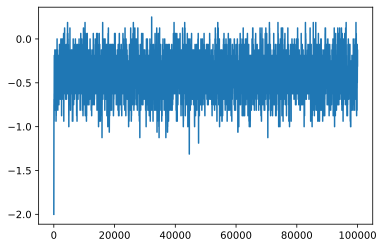

In [46]:
elist = Ising2D_E(5, 100000, N=8)
plt.plot(elist)
%config InlineBackend.figure_format='svg'
plt.show()

##### (1) Energy

In [8]:
from scipy.stats import chi2,halfnorm,t

def Ising2D_E_vec(T,moves,N=16):
	J = 1
	B = 0
	NT=T.size

	slist = np.ones((N,N,NT), dtype=int)
	energylist = np.empty((moves,NT))
	energy = - 2*J * N * N

	for step in track(range(moves)):
		[i,j] = rng.integers(N,size=2)
		dE = 2*J*(slist[(i-1)%N,j] + slist[(i+1)%N,j] + slist[i,(j-1)%N] + slist[i,(j+1)%N])*slist[i,j]
		boollist = rng.random() < np.exp(-dE/T)
		slist[i,j] *= 1-2*boollist
		energy += dE*boollist
		energylist[step] = energy
	validElist = energylist[moves//2:]/(N*N)
	emc = np.mean(validElist,axis=0)
	S=np.std(validElist, ddof=1, axis=0)
	halfn = validElist.size
	errbar = S*t.isf(0.05,halfn-1)/np.sqrt(halfn)
	return emc,errbar

N = 8

Output()

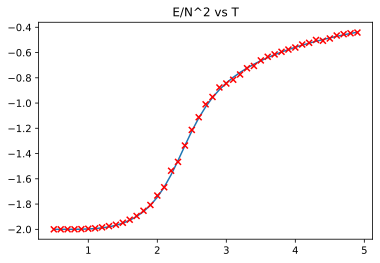

In [11]:
T=np.arange(0.5, 5, step=0.1)
N=8
elist, errbar = Ising2D_E_vec(T, 200000, N=N)
if N in [2,4,8]:
	thElist = E_theory(T,N=N)
	plt.plot(T,thElist)
plt.errorbar(T, elist, yerr=errbar, fmt="None")
plt.scatter(T,elist, marker="x", c="r", zorder=2.5)
plt.title("E/N^2 vs T")
plt.show()

##### (2) Magnetization $M$

$$ M = \left< \sum_i \sigma_i \right> $$

In [16]:
from scipy.stats import chi2,halfnorm,t
def Ising2D_M_vec(T,moves=1000000, N=16):
	J = 1
	B = 0
	NT=T.size

	slist = np.ones((N,N,NT), dtype=int)
	Mlist = np.empty((moves, NT))
	M = N*N

	for step in track(range(moves)):
		[i,j] = rng.integers(N,size=2)
		dE = 2*J*(slist[(i-1)%N,j] + slist[(i+1)%N,j] + slist[i,(j-1)%N] + slist[i,(j+1)%N])*slist[i,j]
		boollist = rng.random() < np.exp(-dE/T)
		slist[i,j] *= 1-2*boollist
		M += 2*slist[i,j]*boollist
		Mlist[step] = M
	# eth = -J*(1+2*(2*(np.tanh(2*J/T)**2)-1)*ellipk(2*np.tanh(2*J/T)/np.cosh(2*J/T)))/np.tanh(2*J/T)
	validMlist = Mlist[moves//2:]/(N*N)
	Mmc = np.mean(validMlist,axis=0)
	S=np.std(validMlist, ddof=1, axis=0)
	halfn = validMlist.size
	errbar = S*t.isf(0.00135,halfn-1)/np.sqrt(halfn)
	return Mmc,errbar

Output()

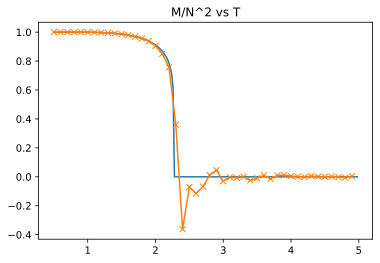

In [17]:
T=np.arange(0.5, 5, step=0.1)
Tt= np.arange(0.5,5,step = 0.02)
N=16
Mlist, errbar = Ising2D_M_vec(T, 1000000, N=N)
a = 1-np.power(np.sinh(2/Tt),-4)
thMlist = np.power(a*(a>0),1/8)
plt.plot(Tt,thMlist)
plt.errorbar(T, Mlist, yerr=errbar, marker="x")
plt.title("M/N^2 vs T")
plt.show()

Metropolis MC method works not very well around the critical temp!

##### (3) heat capacity $C$

$$ C = \frac{\partial \left< E \right>}{\partial T} = \frac{(\Delta E)^2}{T^2} $$

In [18]:
from scipy.stats import chi2,halfnorm,t
def Ising2D_C_vec(T,moves=1000000,N=16):
	J = 1
	B = 0
	NT=T.size

	slist = np.ones((N,N,NT), dtype=int)
	energylist = np.empty((moves,NT))
	energy = - 2*J * N * N

	for step in track(range(moves)):
		[i,j] = rng.integers(N,size=2)
		dE = 2*J*(slist[(i-1)%N,j] + slist[(i+1)%N,j] + slist[i,(j-1)%N] + slist[i,(j+1)%N])*slist[i,j]
		boollist = rng.random() < np.exp(-dE/T)
		slist[i,j] *= 1-2*boollist
		energy += dE*boollist
		energylist[step] = energy
	validElist = energylist[moves//2:]/(N*N)
	halfn = validElist.size
	S=np.std(validElist, ddof=1, axis=0)
	cmc = S*S/(T*T)
	alpha = 0.01
	c1 =chi2.isf(alpha/2, halfn - 1)
	c2 = chi2.isf(1-alpha/2, halfn - 1)
	errbar = np.array([(1-(halfn - 1)/c1)*cmc,((halfn-1)/c2 - 1)*cmc])
	return cmc,errbar

Output()

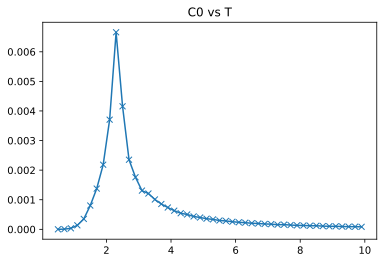

In [19]:
T = np.arange(0.5, 10,step=0.2)
C,errbar = Ising2D_C_vec(T)
plt.errorbar(T, C, yerr=errbar, marker="x")
plt.title("C0 vs T")
plt.show()

##### (4) susceptibility $\chi$

$$ \chi=\frac{\partial M}{\partial T}=\frac{(\Delta M)^{2}}{T}=\frac{\langle M^{2}\rangle-\langle M\rangle^{2}}{T} $$

In [65]:
from scipy.stats import chi2
def Ising2D_chi_vec(T,moves=1000000,N=16):
	J = 1
	B = 0
	NT=T.size

	slist = np.ones((N,N,NT), dtype=int)
	Mlist = np.empty((moves,NT))
	M = J * N * N

	for step in track(range(moves)):
		[i,j] = rng.integers(N,size=2)
		dE = 2*J*(slist[(i-1)%N,j] + slist[(i+1)%N,j] + slist[i,(j-1)%N] + slist[i,(j+1)%N])*slist[i,j]
		boollist = rng.random() < np.exp(-dE/T)
		slist[i,j] *= 1-2*boollist
		M += 2*slist[i,j]*boollist
		Mlist[step] = M
	validMlist = Mlist[moves//2:]/(N*N)
	halfn = validMlist.size
	S=np.std(validMlist, ddof=1, axis=0)
	chimc = S*S/t
	alpha = 0.01
	c1 =chi2.isf(alpha/2, halfn - 1)
	c2 = chi2.isf(1-alpha/2, halfn - 1)
	errbar = np.array([(1-(halfn - 1)/c1)*chimc,((halfn-1)/c2 - 1)*chimc])
	return chimc,errbar

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

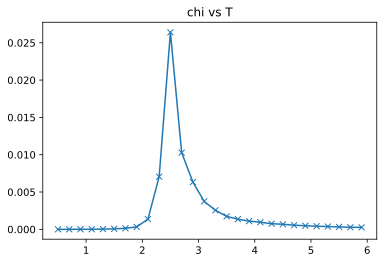

In [67]:
T = np.arange(0.5, 6,step=0.2)
chi,errbar = Ising2D_chi_vec(T)
plt.errorbar(T, chi, yerr=errbar, marker="x")
plt.title("chi vs T")
plt.show()

#### Run over T

Let $T$ vary slowly from high to low.

In [ ]:
# Ising2D_runover_T.py
# too long to show...

![runT](img/runoverT.png)

#### Run over $B$

We relax the $B=0$ condition, and fix $T=1$ (low temperature) --- Just like magnetize an iron block!

Output()

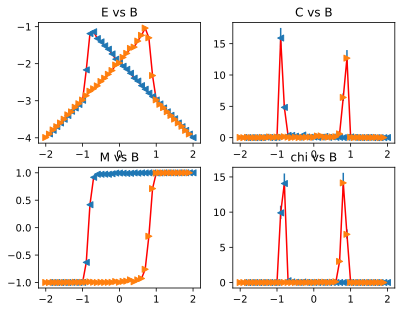

In [8]:
# run external Ising2D_runover_B.py
%config InlineBackend.figure_format='svg'
import Ising2D_runover_B

We can see the path dependence!

## Conclusion

- The Metropolis MC is very fast

- It's also accuracy, except $T \sim T_c$

- The code can be easily reuse for another quantity

- Depends on:
  - `rng`, random number generator
  - a good step $\Delta x$

## Thanks!